In [1]:
%load_ext autoreload
%autoreload 2


In [2]:

from mpm.hand import HandEnv
from mpm.hand import __file__ as env_file_location
from mpm import make
import numpy as np
import os

DATA_DIR = "/".join(env_file_location.split("/")[:-3])
DATA_DIR = os.path.join(DATA_DIR, "data")

env = make(env_name='lift_box', sim_cfg={'max_steps': 4400})


LOADING....
Loaded with 0.0003352165222167969 secs.
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
{'width': (0.09, 0.09, 0.09), 'init_pos': (0.49, 0.22, 0.45), 'n_particles': 10000}
init renderer
GPU 0/8 memory: free=25.069, total=47.544


In [3]:

import matplotlib.pyplot as plt
from mpm.viewer import Viewer
vis = Viewer(env)
vis.refresh_views("obj_centric")
img = vis.render_state_multiview(spp=10, n_views=4)


using object-centric view


using object-centric view


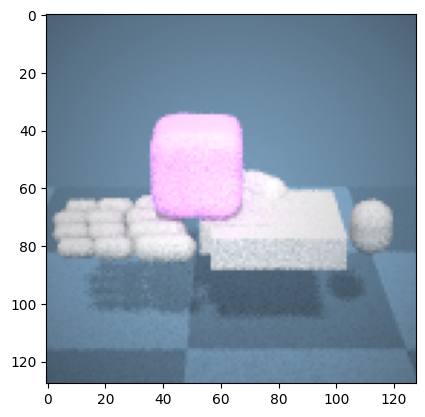

In [4]:
vis.refresh_views('obj_centric', radius=0.1)
vis.set_view("side")
env.simulator.set_state(0, env.init_state)
env.simulator.states[0].x.upload(
    np.random.random(size=(env.simulator.n_particles, 3)) * 0.07 + np.array((0.45, 0.23, 0.45)))
plt.imshow(vis.render())
plt.show()

tmp_state = env.simulator.get_state(0)


In [ ]:
env.simulator.set_state(0, tmp_state)

from mpm.video_utils import write_video
import tqdm

images = []
for i in tqdm.trange(100):
    action = np.ones((1, 26))
    action[:, :20] = np.random.random((1, 20))
    env.simulator.step(action)

    images.append(vis.render(spp=1))

write_video(images, filename="/home/sizheli/data/tmp1.gif")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


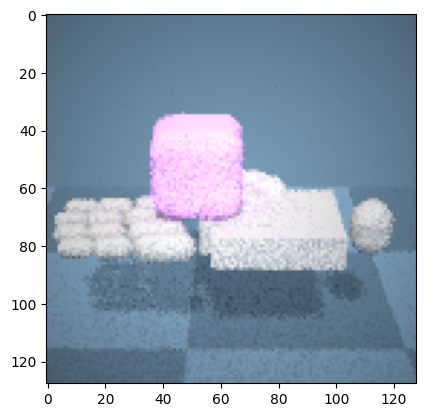

loss: -0.3713493049144745: 100%|██████████| 50/50 [02:13<00:00,  2.67s/it] 


In [7]:
"""

[Diff. Phys. Demo] optimize the action trajectory to lift the box.

"""
import torch
from torch import nn
import tqdm
from mpm.torch_wrapper import GradModel
import matplotlib.pyplot as plt

model = GradModel(env)
env.simulator.set_state(0, tmp_state)
model.zero_grad()
plt.imshow(env.render_rgb())
plt.show()

action = nn.Parameter(env.simulator.togpu(np.zeros(shape=(50, 26))))
optim = torch.optim.Adam([action], lr=0.1)

ran = tqdm.trange(50)

for i in ran:

    optim.zero_grad()
    obs = model.get_obs

    obs = model.get_obs(0, 'cuda:0')
    for j in range(50):
        obs = model.forward(j, action[j:j+1], *obs)

    loss = -obs[0][:, 1].mean()
    loss.backward()

    optim.step()

    ran.set_description(f'loss: {loss}')

In [ ]:

images = []
env.simulator.set_state(0, tmp_state)

for i in tqdm.trange(50):
    env.simulator.step(action[i:i+1].detach().cpu().numpy())
    images.append(vis.render())


animating /home/sizheli/project/self-model/data/tmp1.gif
MoviePy - Building file /home/sizheli/project/self-model/data/tmp1.gif with imageio.


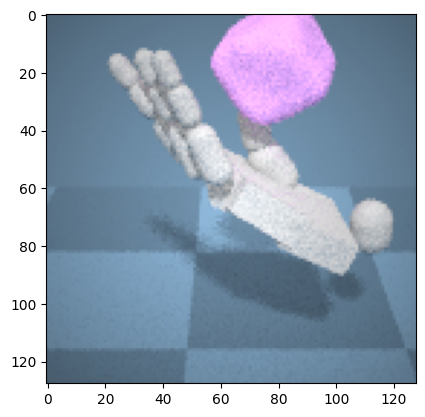

In [10]:
from mpm.video_utils import write_video
write_video(images, filename="/home/sizheli/data/tmp1.gif")

""" Plot the last step result to confirm lifting success """
plt.imshow(images[-1])
plt.show()
